In [32]:
import subprocess
import re
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [33]:
# === CONFIGURATIONS TO TEST ===
configs = [
    ("0.7", "0.0", "DD", "0"),
    ("0.7", "0.0", "CSR", "0"),
    ("0.7", "0.0", "CSR", "1"),
]

repeats = 10
binary = "../../build/benchmark"

# === METRIC STORAGE ===
results = []

def parse_output(output):
    metrics = {}
    lines = output.strip().splitlines()
    for line in lines:
        if "analysis" in line:
            metrics["analysis"] = float(line.split("=")[-1].strip())
        elif "load graph" in line:
            metrics["load"] = float(line.split("=")[-1].strip())
        elif "compilation" in line:
            metrics["compilation"] = float(line.split("=")[-1].strip())
        elif "runtime" in line:
            metrics["runtime"] = float(line.split("=")[-1].strip())
        elif "memory used" in line:
            metrics["memory"] = float(line.split("=")[-1].strip())
    return metrics

# === RUNNING BENCHMARKS ===
for row, col, fmt, opt in configs:
    times = {"analysis": [], "load": [], "compilation": [], "runtime": [], "memory": []}
    for _ in range(repeats):
        cmd = [binary, "graph", row, col, fmt, opt]
        result = subprocess.run(cmd, capture_output=True, text=True)
        metrics = parse_output(result.stdout)
        for k in times:
            times[k].append(metrics.get(k, 0.0))

    # Aggregate
    mean_metrics = {k: statistics.mean(times[k]) for k in times}
    mean_metrics["config"] = f"{row},{col},{fmt},opt={opt}"
    results.append(mean_metrics)

[]

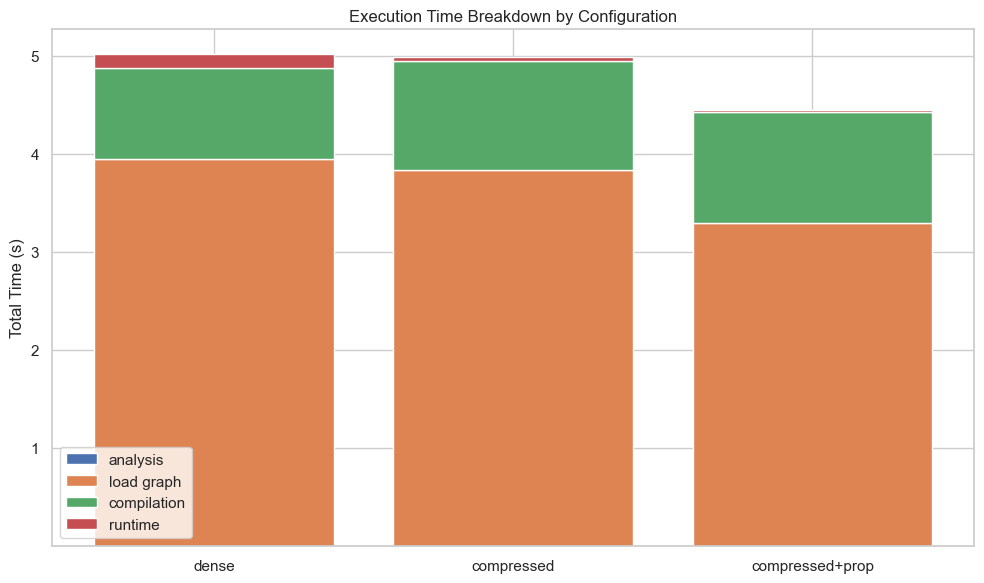

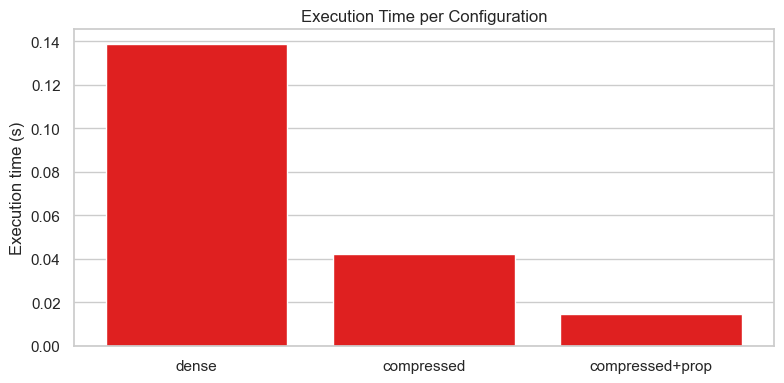

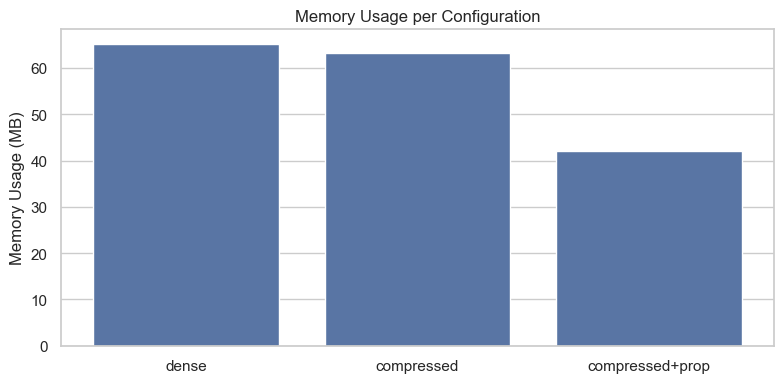

In [34]:
# === PLOT TIME STACK ===
labels = ["dense", "compressed", "compressed+prop"]
load = [r["load"] for r in results]
analysis = [r["analysis"] for r in results]
comp = [r["compilation"] for r in results]
runtime = [r["runtime"] for r in results]

plt.figure(figsize=(10, 6))
plt.bar(labels, analysis, label="analysis")
plt.bar(labels, load, bottom=analysis, label="load graph")
plt.bar(labels, comp, bottom=[a + l for a, l in zip(analysis, load)], label="compilation")
plt.bar(labels, runtime, bottom=[a + l + c for a, l, c in zip(analysis, load, comp)], label="runtime")

plt.ylabel("Total Time (s)")
plt.title("Execution Time Breakdown by Configuration")
#plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.plot()

# === PLOT EXECUTION TIME ===
plt.figure(figsize=(8, 4))
sns.barplot(x=labels, y=runtime,color='red')
plt.ylabel("Execution time (s)")
plt.title("Execution Time per Configuration")
#plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.plot()

# === PLOT MEMORY ===
memory = [r["memory"] for r in results]
plt.figure(figsize=(8, 4))
sns.barplot(x=labels, y=memory)
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Usage per Configuration")
#plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.plot()

